## Feature Extraction

In [39]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle

In [40]:
IMAGE_DIR = "/content/drive/MyDrive/Colab Notebooks/Projects/Image Captioning/dataset/Images"
ARTIFACT_DIR = "/content/drive/MyDrive/Colab Notebooks/Projects/Image Captioning/artifacts"

In [41]:
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image,text

In [42]:
vgg16_model = VGG16(weights='imagenet')

In [43]:
feature_extractor_model = models.Model(inputs = vgg16_model.inputs,
                                       outputs = vgg16_model.layers[-2].output)

In [44]:
feature_extractor_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [45]:
def extract_feature(IMAGE_DIR):
  image_feature_map = {}
  for image_name in tqdm(os.listdir(IMAGE_DIR)):
    img_path = os.path.join(IMAGE_DIR,image_name)
    img = image.load_img(img_path,target_size = (224,224))
    img = image.img_to_array(img)
    img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
    img = preprocess_input(img)
    img_id = image_name.split('.')[0]
    extracted_feature = feature_extractor_model.predict(img,verbose=0)
    image_feature_map[img_id] = extracted_feature
  return image_feature_map

In [46]:
# image_feature_map = extract_feature(IMAGE_DIR)
# with open(os.path.join(ARTIFACT_DIR,"image_feature_map.pkl"),"wb") as img_feat_map:
#   pickle.dump(image_feature_map,img_feat_map)

with open(os.path.join(ARTIFACT_DIR,"image_feature_map.pkl"),"rb") as img_feat_map:
  image_feature_map = pickle.load(img_feat_map)

## Caption Preprocessing

In [47]:
import re,nltk

In [48]:
def preprocess_caption(caption_path):
  image_caption_map = {}
  with open(caption_path,"r") as f:
    next(f)
    caption_file = f.read()

  for image_name_caption in tqdm(caption_file.split("\n")):
    if len(image_name_caption)<2:
      continue
    line = image_name_caption.split(",")
    image_name,caption = line[0],line[1:]
    caption = " ".join(caption)
    caption = caption.lower()
    caption = re.sub(r'[^a-z\s]+',"",caption)
    caption = re.sub(r'\s+'," ",caption)
    caption = caption.strip()
    caption = "startseq " + caption + " endseq"
    image_name = image_name.split('.')[0]
    caption = " ".join([word for word in caption.split() if len(word)>1])
    if image_name not in image_caption_map:
      image_caption_map[image_name] = []
    image_caption_map[image_name].append(caption)


  return image_caption_map

caption_path = "/content/drive/MyDrive/Colab Notebooks/Projects/Image Captioning/dataset/captions.txt"
# image_caption_map = preprocess_caption(caption_path)
# with open(os.path.join(ARTIFACT_DIR,"image_caption_map.pkl"),"wb") as f:
#   pickle.dump(image_caption_map,f)

with open(os.path.join(ARTIFACT_DIR,"image_caption_map.pkl"),"rb") as f:
  image_caption_map = pickle.load(f)

In [49]:
image_caption_map['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [50]:
all_captions = []
for image_name,captions in image_caption_map.items():
  all_captions.extend(captions)

In [51]:
len(all_captions)

40455

In [52]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [53]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

8768

In [54]:
max_caption_len = max(len(caption.split()) for caption in all_captions)
max_caption_len

34

In [55]:
image_names = list(image_caption_map.keys())
split = int(len(image_names)*0.90)
train = image_names[:split]
test = image_names[split:]
print(len(train))
print(len(test))

7281
810


In [56]:
import numpy as np
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [57]:
def data_generator(image_names,tokenizer,image_feature_map,image_caption_map,max_caption_len,vocab_size,batch_size=32):
  X1, X2, y = list(), list(), list()
  counter = 0
  while True:
    for image_name in image_names:
      counter += 1
      captions = image_caption_map[image_name]

      for caption in captions:
        sequence = tokenizer.texts_to_sequences([caption])[0]

        for i in range(1,len(sequence)):
          input_seq,output_seq = sequence[:i],sequence[i]
          input_seq = pad_sequences([input_seq],maxlen=max_caption_len)[0]
          output_seq = to_categorical([output_seq],num_classes = vocab_size)[0]

          X1.append(image_feature_map[image_name][0])
          X2.append(input_seq)
          y.append(output_seq)

      if counter==batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield [X1,X2],y

        X1, X2, y = list(), list(), list()
        counter = 0

In [58]:
input1 = layers.Input(shape=(4096,))
dropout_layer_fe = layers.Dropout(0.5)(input1)
fc3 = layers.Dense(units=256,activation='relu')(dropout_layer_fe)

In [59]:
input2 = layers.Input(shape=(max_caption_len,))
embedding_layer = layers.Embedding(input_dim = vocab_size, output_dim = 256, mask_zero=True)(input2)
dropout_layer_en = layers.Dropout(0.5)(embedding_layer)
lstm_layer = layers.LSTM(256)(dropout_layer_en)

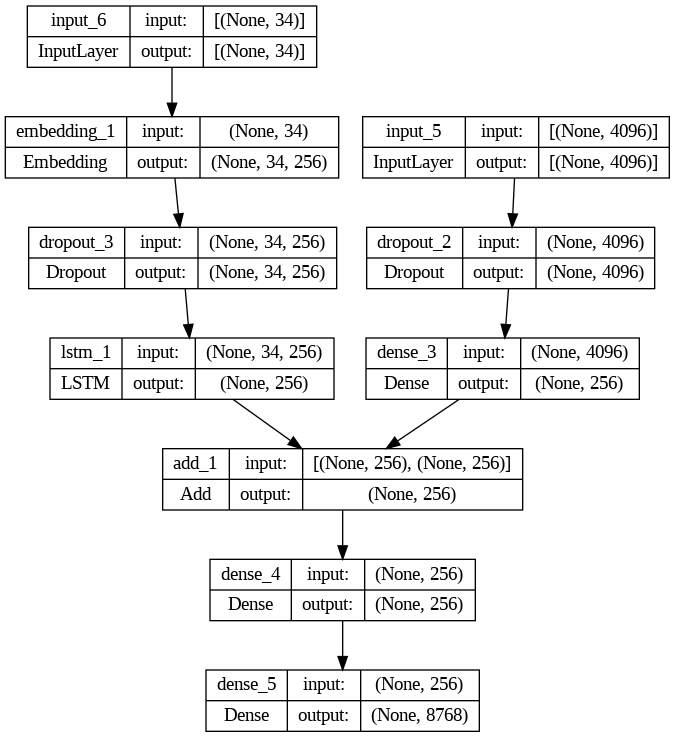

In [60]:
fc3 = layers.add([fc3,lstm_layer])
fc4 = layers.Dense(units = 256,activation='relu')(fc3)
fc5 = layers.Dense(units=vocab_size,activation = "softmax")(fc4)

model = models.Model(inputs = [input1,input2], outputs=fc5)
model.compile(loss='categorical_crossentropy',optimizer='adam')

plot_model(model,show_shapes=True)

In [61]:
epochs = 100
batch_size = 32
steps = len(train)//batch_size

for i in range(epochs):
  data_gen = data_generator(train,
               tokenizer,
               image_feature_map,
               image_caption_map,
               max_caption_len,
               vocab_size,
               batch_size
               )
  model.fit(data_gen,epochs=1,steps_per_epoch=steps, verbose=1)

  4/227 [..............................] - ETA: 1:20 - loss: 1.8983

KeyboardInterrupt: 

In [63]:
version = 2
# model.save(os.path.join(ARTIFACT_DIR,f"vgg16_lstm_model_v{version}.keras"))
model = models.load_model(os.path.join(ARTIFACT_DIR,f"vgg16_lstm_model_v{version}.keras"))

In [64]:
def index_to_word(tokenizer,ind):
  output_word = None
  for word,index in tokenizer.word_index.items():
    if index==ind:
      output_word = word
      break
  return output_word

In [65]:
def predict_caption(model,image_feature,max_caption_len,tokenizer):
  output = "startseq"
  temp_output = [output]
  for i in range(max_caption_len):
    seq = tokenizer.texts_to_sequences([output])[0]
    seq = pad_sequences([seq],max_caption_len)
    y_pred = model.predict([image_feature,seq],verbose=0)
    y_pred = np.argmax(y_pred)
    word = index_to_word(tokenizer,y_pred)
    if word is None:
      break
    output = output + " " + word
    if word == "endseq":
      break
  return output

In [92]:
def get_caption(image_name,image_feature_map,image_caption_map,max_caption_len):
  image_id = image_name.split(".")[0]
  image_path = os.path.join(IMAGE_DIR,image_name)
  img = image.load_img(image_path)
  actual_captions = image_caption_map[image_id]
  image_feature = image_feature_map[image_id]
  print("------------Actual captions--------------")
  for caption in actual_captions:
    print(caption)
  predicted_caption = predict_caption(model,image_feature,max_caption_len,tokenizer)
  print("\n------------Predicted caption------------")
  print(predicted_caption)
  plt.imshow(img)
  plt.axis('off')

------------Actual captions--------------
startseq the back of two men heads riding on train endseq
startseq the backs of the heads of two men that are plugging their ears while riding the subway endseq
startseq two guys are sharing headphones and are listening to music on subway endseq
startseq two men on busy subway seen from behind endseq
startseq two people sitting together on subway listening to earphones endseq

------------Predicted caption------------
startseq two men heads down the subway listening to earphones endseq


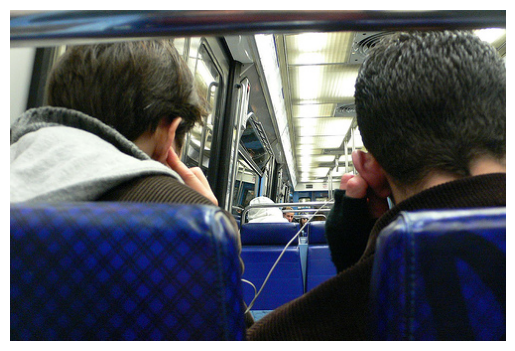

In [94]:
random_image_id = list(image_caption_map.keys())[np.random.randint(0,len(image_caption_map))]
image_name = f"{random_image_id}.jpg"
get_caption(image_name,image_feature_map,image_caption_map,max_caption_len)

In [71]:
from nltk.translate.bleu_score import corpus_bleu

In [88]:
def get_bleu_score(model,test,image_caption_map,image_feature_map,max_caption_len,tokenizer):
  actual, predicted = list(), list()
  for image_id in tqdm(test):
    captions = image_caption_map[image_id]
    image_feature = image_feature_map[image_id]
    y_pred =  predict_caption(model,image_feature,max_caption_len,tokenizer)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    return (bleu_1,bleu_2)


In [89]:
bleu_1, bleu_2 = get_bleu_score(model,test,image_caption_map,image_feature_map,max_caption_len,tokenizer)
print(f"BLEU-1: {bleu_1}")
print(f"BLEU-2: {bleu_2}")

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.4412484512922977
BLEU-2: 9.308300767049977e-155
